# Route Gallery: Small Multiples
This notebook visualizes the shapes of your activities as a grid of small multiples. It decodes the summary polylines from Strava and normalizes them to a consistent scale, creating an artistic representation of your paths.

In [1]:
import pandas as pd
import polyline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

## 1. Load Data

In [2]:
def load_data(path="../data/processed/activities.parquet"):
    df = pd.read_parquet(path)
    # Filter for activities with map data
    df = df[df['map_polyline'].notna() & (df['map_polyline'] != "")]
    # Sort by date (newest first)
    df['start_date'] = pd.to_datetime(df['start_date'])
    df = df.sort_values('start_date', ascending=False)
    return df

df = load_data()
print(f"Loaded {len(df)} activities with map data.")

Loaded 2089 activities with map data.


## 2. Processing and Normalization
We decode the polyline strings into (lat, lon) pairs and then normalize them so they all fit within a 0-1 range while maintaining their original aspect ratio.

In [3]:
def decode_and_normalize(polyline_str):
    try:
        coords = polyline.decode(polyline_str)
        if not coords:
            return None
        
        coords = np.array(coords)
        # Normalize to 0-1 scale
        min_vals = coords.min(axis=0)
        max_vals = coords.max(axis=0)
        ranges = max_vals - min_vals
        
        # Avoid division by zero
        if np.any(ranges == 0):
            return coords - min_vals
            
        # Normalize while preserving aspect ratio
        max_range = ranges.max()
        norm_coords = (coords - min_vals) / max_range
        
        return norm_coords
    except Exception as e:
        return None

## 3. Visualization
Create a grid of small multiples. We'll show the most recent 100 activities in a 10x10 grid.

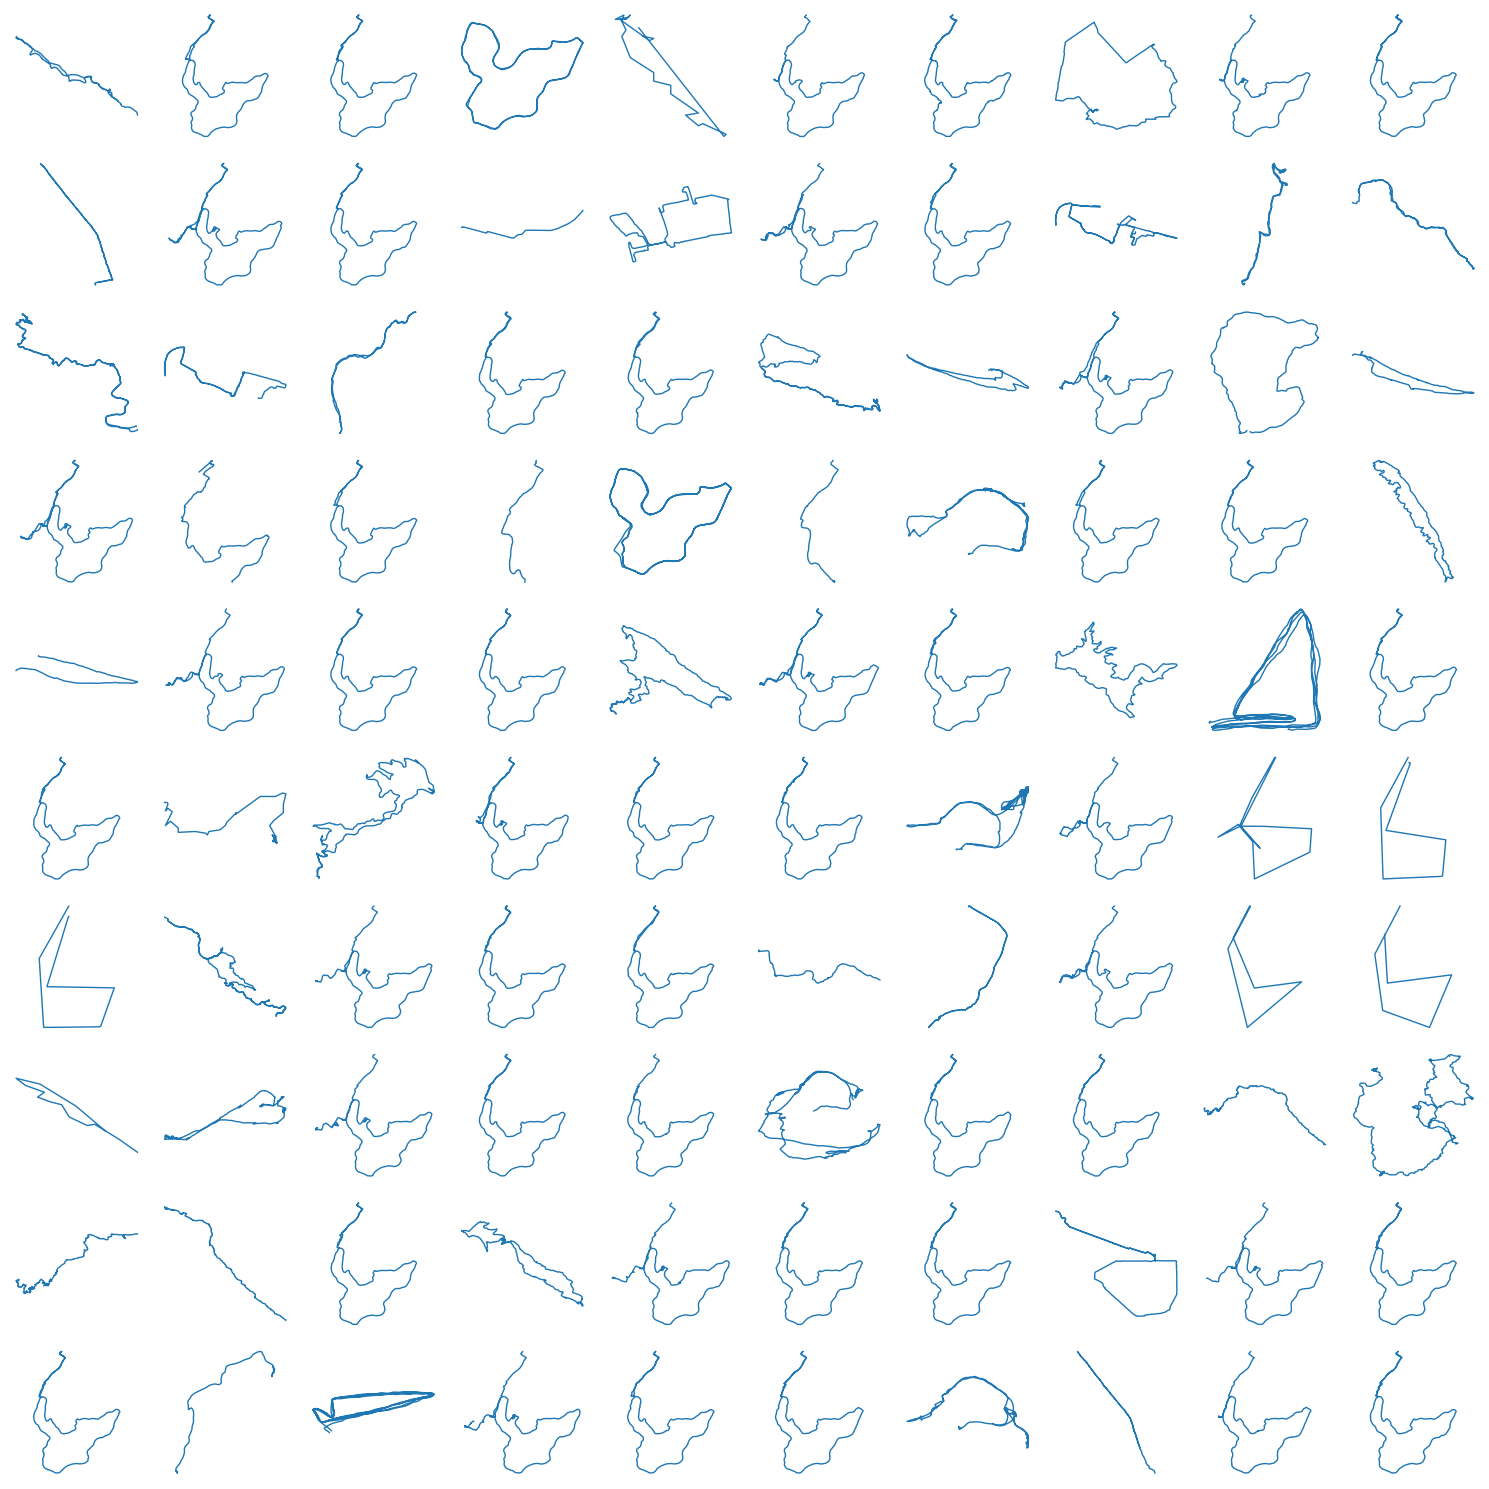

In [4]:
def plot_gallery(df, num_items=100, cols=10):
    subset = df.head(num_items)
    rows = int(np.ceil(num_items / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    axes = axes.flatten()
    
    for i, (idx, row) in enumerate(subset.iterrows()):
        ax = axes[i]
        norm_coords = decode_and_normalize(row['map_polyline'])
        
        if norm_coords is not None:
            # Lat, Lon -> Y, X for plotting
            ax.plot(norm_coords[:, 1], norm_coords[:, 0], color='#1f77b4', linewidth=1)
        
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Optional: Title with date or type
        # ax.set_title(f"{row['start_date'].strftime('%Y-%m-%d')}", fontsize=8)
        
    # Clear unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

plot_gallery(df)